# Tutorial 1: Spatial CITE-seq (Human Tonsil)

DePass was applied to the human tonsil spatial CITE-seq dataset (2,492 spatial spots) for cross-modal integration and data enhancement. This tutorial demonstrates: 

1. Spatial domain identification in tonsil tissue using DePass.
2. Validation of data enhancement through comparative analysis of biomarker log2 fold-changes (LogFC) and spatial expression patterns.
3. In addition, random masked data and random noisy data were constructed for DePass integration, demonstrating DePass's ability to recover biologically meaningful signals. 


### Preparation

In [ ]:
import scanpy as sc
import torch
import random
import pandas as pd
import numpy as np
import os
import warnings

warnings.filterwarnings("ignore")
from DePass.utils import *

fix_seed(2024)  

# Environment configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

os.environ['R_HOME'] = '/home/jyx/anaconda3/envs/DePass/lib/R'
   
path = '../data/dataset_HumanTonsil'
os.mkdir(path) if not os.path.exists(path) else print(f"The directory '{path}' already exists.\n")

### Loading and Preprocessing

Load the raw count data and perform preprocessing to ensure high-quality input for model. The preprocessing methods are detailed below:
For transcriptomics, we filtered gene features to retain those detected in ≥1% of cells. Top 1,000 highly variable genes (HVGs) were selected via Seurat v3 dispersion-based method. Counts were normalized per cell (total scaling to 10^4), followed by log1p transformation and z-score standardization via scanpy package. For proteomics, protein expression matrices were normalized using centered log-ratio (CLR) transformation to address compositionality biases, followed by feature-wise z-score standardization.

In [ ]:
adata_omics1 = sc.read_h5ad('../data/dataset_HumanTonsil/adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad('../data/dataset_HumanTonsil/adata_ADT.h5ad')

preprocess_data(adata=adata_omics1,modality='rna')
preprocess_data(adata=adata_omics2,modality='protein')

adata_omics1.obsm['input_feat'] = adata_omics1.obsm['X_norm'].copy()
adata_omics2.obsm['input_feat'] = adata_omics2.obsm['X_clr'].copy()
data = {'rna': adata_omics1, 'protein': adata_omics2}


### Training the model

The DePass model is designed for multi-omics data integration at both spatial and single-cell data. After training, the output file includes the following key results:

1. **`embedding`**: Integrated embedding representation, which integrates multi-omics expression features with spatial coordinate information (for spatial data). This representation is used directly for downstream tasks (e.g., spatial domain segmentation) or visualization (e.g., UMAP). 
2. **`x1_enh`**: Enhanced feature matrix for the first omics modality.  
3. **`x2_enh`**: Enhanced feature matrix for the second omics modality.  
4. **`alpha`**: Cross-modality attention weight matrix, dynamically learned through a attention mechanism. It reflects the relative importance of each modality in clustering units (e.g., cells/spots/bins).

In [ ]:
from DePass.model import DePass
# data (dict): Input data dictionary containing multiple modality data. 
# data_type (str, optional): Data type, which can be 'spatial' or 'single_cell'.  
# epochs (int, optional): Total number of training epochs. Defaults to 200. 
# batch_training (bool, optional): Whether to use batch training. Defaults to False. 
model = DePass(data, data_type='spatial',device=device)
output = model.train()

[Config]
Modalities: 2 | Data: spatial | Device: NVIDIA GeForce RTX 4090 

[Initializing]
Graph Construction : Running...
Graph Construction : Done!
Data Enhancement : Running...
Data Enhancement : Done!

[Training]
Model training starts...


100%|██████████| 200/200 [00:02<00:00, 70.81it/s]

Model training finished!



In [ ]:
adata = adata_omics1.copy()
adata.obsm['DePass'] = model.embedding
adata.obsm['alpha'] = model.alpha 
adata.obsm['x1_enh'] = model.x1_enh
adata.obsm['x2_enh'] = model.x2_enh

### Detect spatial domain 

After the model is trained, we use the integrated representation for cluster analysis. Here we provide three optional clustering tools, including **mclust**, **leiden**, and **kmeans**. We recommend using the **mclust** algorithm for clustering and specifying the number of target clusters. In this example, we set the number of clusters to 7 and use PCA for dimensionality reduction by setting `use_pca=True`.  The clustering results are stored in the `adata` object under the key `'DePass'`. 

For visualization, we perform **spatial visualization of regions** using **matplotlib**, where colors correspond to the cluster assignments. 



In [ ]:
from DePass.utils import *
clustering(adata=adata,n_clusters=7,key='DePass',add_key='DePass',method='mclust',use_pca=True)


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


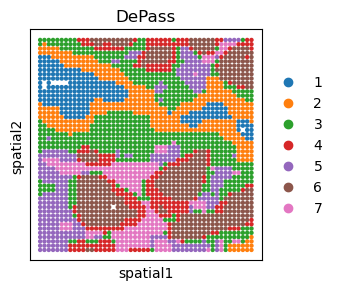

In [ ]:
from DePass.analyze_utils import plot_spatial

plot_spatial(
    adata,
    color='DePass',
    save_path=path,
    save_name='DePass',
    title="DePass",
    s=40,
    dpi=300,
    format='pdf',
    frameon =True,
    colorbar_loc='right', 
    show=True,
)


In [ ]:
adata.write(path+'/adata.h5ad')

### Visualization of the attention weights
The attention mechanism dynamically learns weights across all modalities for each individual cell (spots/bins). These weights reveal relative importance of different modalities (transcriptomics, proteomics). High proteomics weights within a cluster indicate that proteomic data significantly drives the molecular characterization of that cluster.

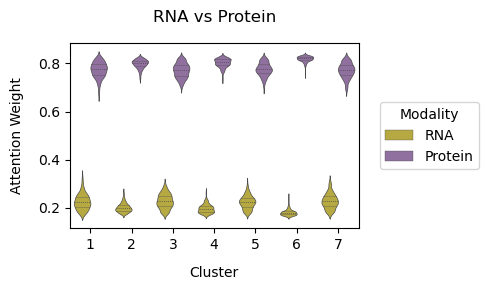

<Axes: title={'center': 'RNA vs Protein'}, xlabel='Cluster', ylabel='Attention Weight'>

In [ ]:
from DePass.analyze_utils import plot_modality_weights
palette = {"RNA": "#9F0000", "Protein": "#003A75"}
plot_modality_weights(
    adata,
    save_path=path,
    save_name="rna_protein_weights",
    figsize=(5, 3),
)

### Data Enhancement Analysis


Perform differential expression analysis using **scanpy**. Set the grouping variable to 'DePass'. Rank genes with the 'wilcoxon' method to calculate log-fold change (logFC) values. 



In [ ]:
adata1_high = adata_omics1[:,adata_omics1.var['highly_variable']]
# adata1_high.write(path+'/adata1_high.h5ad')
# adata_omics2.write(path+'/adata_omics2.h5ad')

In [ ]:
import anndata as ad
# Create two AnnData objects to store the raw and enhanced data. 
adata2_R = ad.AnnData(X=adata_omics2.obsm['X_clr'], obs=adata.obs[['DePass']].copy(), var=adata_omics2.var.copy(), obsm={'spatial': adata_omics2.obsm['spatial'].copy()})
adata2_E = ad.AnnData(X=adata.obsm['x2_enh'], obs=adata.obs[['DePass']].copy(), var=adata_omics2.var.copy(), obsm={'spatial': adata_omics2.obsm['spatial'].copy()})


In [ ]:
# adata2_R = sc.read(path+'/adata2_R.h5ad')
# adata2_E = sc.read(path+'/adata2_E.h5ad')

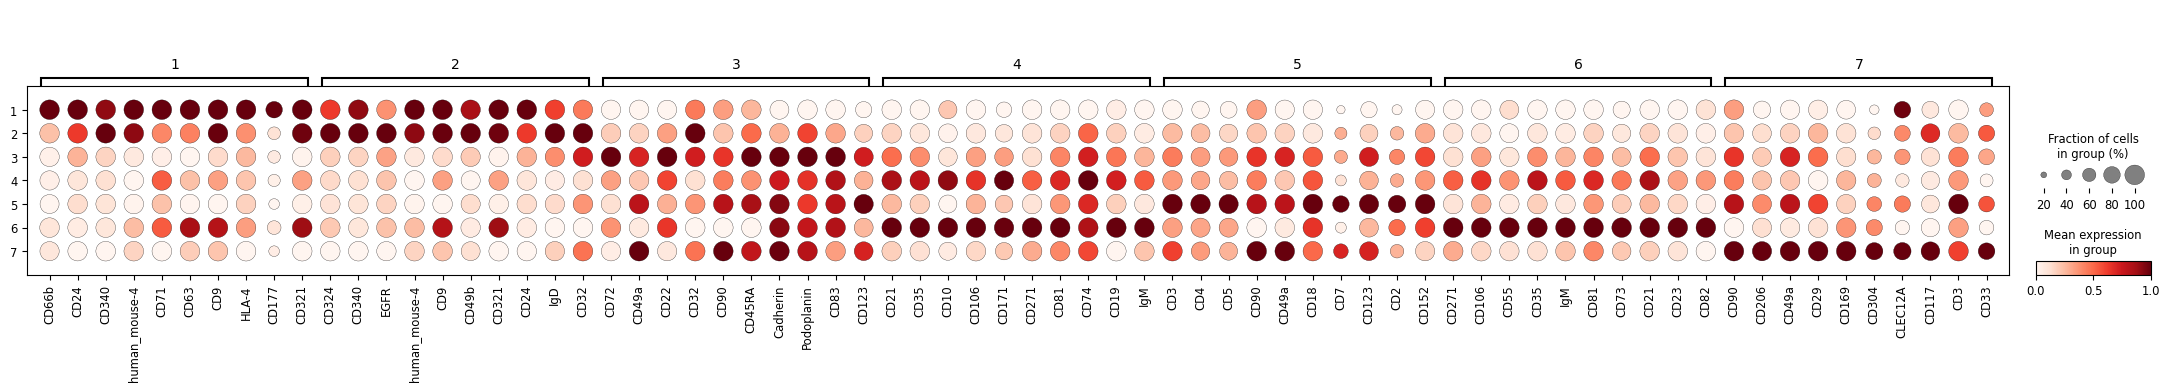

In [ ]:
from DePass.analyze_utils import rank_genes_groups
rank_genes_groups(adata=adata2_R, save_path=path, groupby='DePass', figname='rank_x2_R', method='wilcoxon', n_genes=10,show=True)
rank_genes_groups(adata=adata2_E, save_path=path, groupby='DePass', figname='rank_x2_E', method='wilcoxon', n_genes=10,show=False)

In [10]:
adata2_R.write(path+'/adata2_R.h5ad')
adata2_E.write(path+'/adata2_E.h5ad')


### Comparison of Spatial Expression Patterns and LogFC for Markers

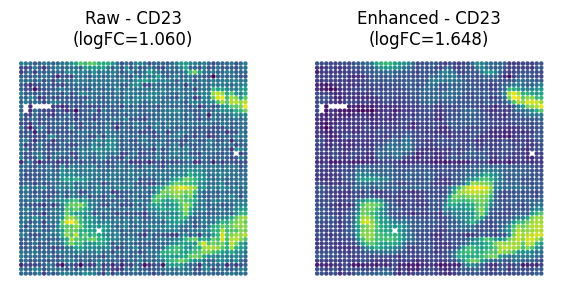

In [4]:
from DePass.analyze_utils import plot_marker_comparison_with_logFC

# The user needs to specify the clustering corresponding to each marker. 
# For example, if you are analyzing the gene CD23 in group 6, you would set target_gene = 'CD23' and target_group = '6'.
plot_marker_comparison_with_logFC(adata2_R, adata2_E, target_gene='CD23', target_group='6', save_path=path, save_name='CD23', s=40, dpi=300, show=True)

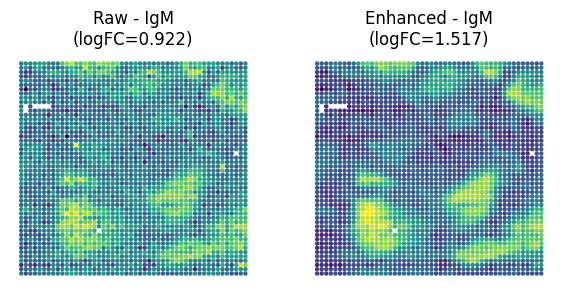

In [6]:
from DePass.analyze_utils import *
plot_marker_comparison_with_logFC(adata2_R, adata2_E, target_gene='IgM', target_group='6', save_path=path, save_name='IgM', s=40, dpi=300, show=True)

### DePass for noisy data


To evaluate the robustness of DePass to data disturbances and the ability of its data enhancement mechanism to repair disturbed data, we introduced controlled Gaussian noise into both RNA and protein patterns. Specifically, DePass generates integrated representations and enhancement features from perturbed inputs. 

The details of noise data generation are as follows: For each input mode, Gaussian noise with a mean of 0 and a standard deviation of 1.5 (a predefined noise level) is added to the preprocessed data prior to model input.





In [ ]:
noise_level =1.5

from DePass.analyze_utils import noise
noisy_data1, noisy_data2 = noise(adata_omics1,adata_omics2,noise_level)

adata_omics1.obsm['input_feat'] = noisy_data1
adata_omics2.obsm['input_feat'] = noisy_data2
data = {'rna': adata_omics1, 'protein': adata_omics2}

In [ ]:
model_N = DePass(data, data_type='spatial',device=device)  
model_N.train()

adata.obsm['DePass_noise'] = model_N.embedding
adata.obsm['x2_enh_noise'] = model_N.x2_enh

import anndata as ad
# Create two AnnData objects to store the noisy and enhanced noisy data. 
adata2_R_noise = ad.AnnData(X=noisy_data2, obs=adata.obs[['DePass']].copy(), var=adata_omics2.var.copy(), obsm={'spatial': adata_omics2.obsm['spatial'].copy()})
adata2_E_noise = ad.AnnData(X=adata.obsm['x2_enh_noise'], obs=adata.obs[['DePass']].copy(), var=adata_omics2.var.copy(), obsm={'spatial': adata_omics2.obsm['spatial'].copy()})

[Config]
Modalities: 2 | Data: spatial | Device: NVIDIA GeForce RTX 4090 

[Initializing]
Graph Construction : Running...
Graph Construction : Done!
Data Enhancement : Running...
Data Enhancement : Done!

[Training]
Model training starts...


100%|██████████| 200/200 [00:01<00:00, 104.04it/s]

Model training finished!



### DePass for maskded data 

Masked Data Generation details: Random masking was implemented through modality-specific protocols: For transcriptomic data, non-zero entries were randomly masked (mask ratio:) following high-variance gene (HVG) selection. Proteomic features were masked prior to centered log-ratio (CLR) normalization. 

In [ ]:
from DePass.analyze_utils import Generate_masked_data


adata1_raw=sc.read_h5ad('../data/dataset_HumanTonsil/adata_RNA.h5ad')
adata2_raw=sc.read_h5ad('../data/dataset_HumanTonsil/adata_ADT.h5ad')
masked_data1, masked_data2 = Generate_masked_data(adata1_raw,adata2_raw,mask_ratio=0.16)

adata_omics1.obsm['input_feat'] = masked_data1
adata_omics2.obsm['input_feat'] = masked_data2
data = {'rna': adata_omics1, 'protein': adata_omics2}

In [ ]:
model_M = DePass(data, data_type='spatial',device=device)  
model_M.train()

adata.obsm['DePass_mask'] = model_M.embedding
adata.obsm['x2_enh_mask'] = model_M.x2_enh

import anndata as ad
# Create two AnnData objects to store the masked and enhanced masked data. 
adata2_R_mask = ad.AnnData(X=masked_data2, obs=adata.obs[['DePass']].copy(), var=adata_omics2.var.copy(), obsm={'spatial': adata_omics2.obsm['spatial'].copy()})
adata2_E_mask = ad.AnnData(X=adata.obsm['x2_enh_mask'], obs=adata.obs[['DePass']].copy(), var=adata_omics2.var.copy(), obsm={'spatial': adata_omics2.obsm['spatial'].copy()})

[Config]
Modalities: 2 | Data: spatial | Device: NVIDIA GeForce RTX 4090 

[Initializing]
Graph Construction : Running...
Graph Construction : Done!
Data Enhancement : Running...
Data Enhancement : Done!

[Training]
Model training starts...


100%|██████████| 200/200 [00:01<00:00, 100.22it/s]

Model training finished!



### Data Enhancement Analysis: Clustering

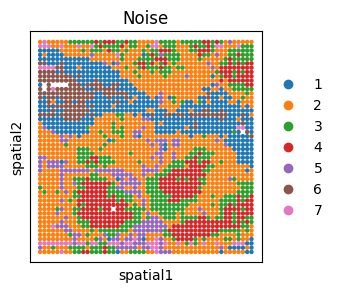

In [ ]:
from DePass.utils import *
clustering(adata=adata2_R_noise,n_clusters=7,use_X=True,add_key='noise',method='mclust',use_pca=True)

from DePass.analyze_utils import *
plot_spatial(
    adata2_R_noise,
    color='noise',
    save_path=path,
    title="Noise",
    save_name="Noise",
    s=40,
    dpi=300,
    frameon=True,
    format='pdf',
    show=True,
)

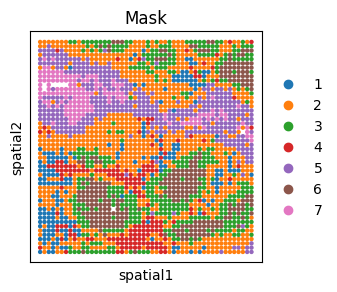

In [ ]:
from DePass.utils import *
clustering(adata=adata2_R_mask,n_clusters=7,use_X=True,add_key='mask',method='mclust',use_pca=True)


plot_spatial(
    adata2_R_mask,
    color='mask',
    save_path=path,
    title="Mask",
    save_name="Mask",
    s=40,
    dpi=300,
    frameon=True,
    format='pdf',
    show=True,
)

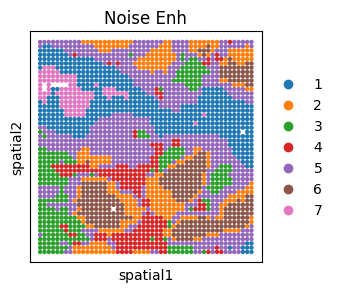

In [ ]:
from DePass.utils import *
clustering(adata=adata2_E_noise,n_clusters=7,use_X=True,add_key='noise enh',method='mclust',use_pca=True)


plot_spatial(
    adata2_E_noise,
    color='noise enh',
    save_path=path,
    title="Noise Enh",
    save_name="Noise Enh",
    s=40,
    dpi=300,
    frameon=True,
    format='pdf',
    show=True
)


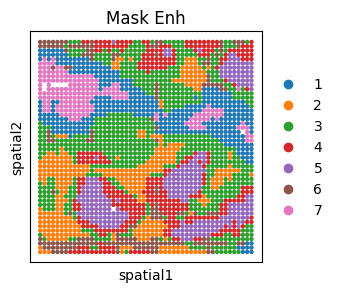

In [ ]:
from DePass.utils import *
clustering(adata=adata2_E_mask,n_clusters=7,use_X=True,add_key='mask enh',method='mclust',use_pca=True)


plot_spatial(
    adata2_E_mask,
    color='mask enh',
    save_path=path,
    title="Mask Enh",
    save_name='Mask Enh',
    s=40,
    dpi=300,
    frameon=True,
    format='pdf',
    show=True,
)


In [ ]:
adata2_R_noise.write(path+'/adata2_R_noise.h5ad')
adata2_E_noise.write(path+'/adata2_E_noise.h5ad')
adata2_R_mask.write(path+'/adata2_R_mask.h5ad')
adata2_E_mask.write(path+'/adata2_E_mask.h5ad')

In [8]:
adata2_R_noise = sc.read(path+'/adata2_R_noise.h5ad')
adata2_E_noise = sc.read(path+'/adata2_E_noise.h5ad')
adata2_R_mask = sc.read(path+'/adata2_R_mask.h5ad')
adata2_E_mask = sc.read(path+'/adata2_E_mask.h5ad')

### Data Enhancement Analysis: Marker LogFC and Expression Pattern


Perform differential expression analysis using **scanpy**. Set the grouping variable to 'DePass'. Rank genes with the 'wilcoxon' method to calculate log-fold change (logFC) values. 



In [4]:
from DePass.analyze_utils import rank_genes_groups
rank_genes_groups(adata=adata2_R_noise, groupby='DePass', method='wilcoxon', n_genes=10,show=False)
rank_genes_groups(adata=adata2_E_noise, groupby='DePass', method='wilcoxon', n_genes=10,show=False)
rank_genes_groups(adata=adata2_R_mask , groupby='DePass', method='wilcoxon', n_genes=10,show=False)
rank_genes_groups(adata=adata2_E_mask , groupby='DePass', method='wilcoxon', n_genes=10,show=False)

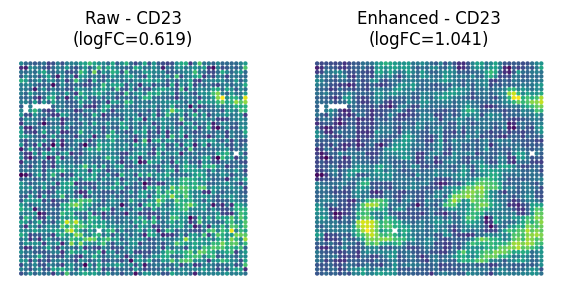

In [15]:
# The user needs to specify the clustering corresponding to each marker. 
# For example, if you are analyzing the gene CD23 in group 6, you would set target_gene = 'CD23' and target_group = '6'.
plot_marker_comparison_with_logFC(adata2_R_noise, adata2_E_noise, target_gene='CD23', target_group='6', save_path=path, save_name='CD23', s=40, dpi=300, show=True)

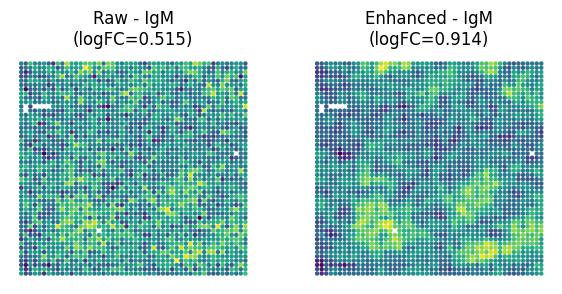

In [16]:
from DePass.analyze_utils import plot_marker_comparison_with_logFC

plot_marker_comparison_with_logFC(adata2_R_noise, adata2_E_noise, target_gene='IgM', target_group='6', save_path=path, save_name='IgM', s=40, dpi=300, show=True)

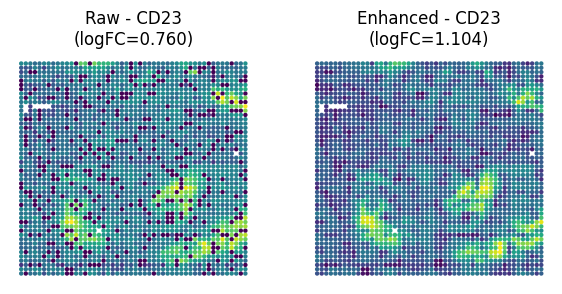

In [17]:
# The user needs to specify the clustering corresponding to each marker. 
# For example, if you are analyzing the gene CD23 in group 6, you would set target_gene = 'CD23' and target_group = '6'.
plot_marker_comparison_with_logFC(adata2_R_mask, adata2_E_mask, target_gene='CD23', target_group='6', save_path=path, save_name='CD23', s=40, dpi=300, show=True)


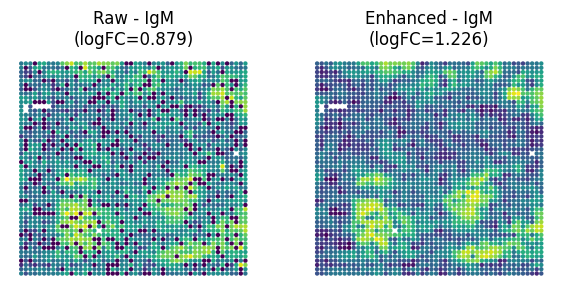

In [18]:
from DePass.analyze_utils import plot_marker_comparison_with_logFC
plot_marker_comparison_with_logFC(adata2_R_mask, adata2_E_mask, target_gene='IgM', target_group='6', save_path=path, save_name='IgM', s=40, dpi=300, show=True)

## logFC comparison

In [ ]:

MASK = "M"
MASK_ENH = "M+"
NOISE = "N"
NOISE_ENH = "N+" 
RAW = "R"
RAW_ENH = "R+"

name=[MASK, MASK_ENH,NOISE, NOISE_ENH, RAW, RAW_ENH]


target_genes = ['CD23', 'IgM','CD21','CD171','CD35','CD3', 'CD4','CD5'] 
target_groups = ['6']*5 +  ['5']*3  # The user needs to specify the clustering corresponding to each marker. 

from DePass.analyze_utils import get_logfc_df
long_df = get_logfc_df(
    adata_list=[adata2_R_mask, adata2_E_mask,adata2_R_noise, adata2_E_noise, adata2_R, adata2_E],
    adata_names=name,
    target_genes=target_genes,
    target_groups=target_groups,
    save_path=path,
    save_name="marker_logfc_comparison"
)

# print(long_df)

     Gene Group type     logFC
0    CD23     6    M  0.759838
1     IgM     6    M  0.878637
2    CD21     6    M  0.490633
3   CD171     6    M  0.907568
4    CD35     6    M  0.641030
5     CD3     5    M  0.772915
6     CD4     5    M  0.741289
7     CD5     5    M  0.842632
8    CD23     6   M+  1.103906
9     IgM     6   M+  1.225543
10   CD21     6   M+  0.689494
11  CD171     6   M+  1.035864
12   CD35     6   M+  0.894980
13    CD3     5   M+  0.875363
14    CD4     5   M+  0.821094
15    CD5     5   M+  0.904210
16   CD23     6    N  0.618903
17    IgM     6    N  0.514847
18   CD21     6    N  0.494527
19  CD171     6    N  0.337942
20   CD35     6    N  0.476990
21    CD3     5    N  0.463359
22    CD4     5    N  0.311420
23    CD5     5    N  0.299364
24   CD23     6   N+  1.041034
25    IgM     6   N+  0.913508
26   CD21     6   N+  0.913057
27  CD171     6   N+  0.709791
28   CD35     6   N+  0.890313
29    CD3     5   N+  0.761227
30    CD4     5   N+  0.559068
31    CD

In [13]:
long_df.to_csv(path+'/df_logFC.csv',sep='\t')

['M', 'M+', 'N', 'N+', 'R', 'R+']


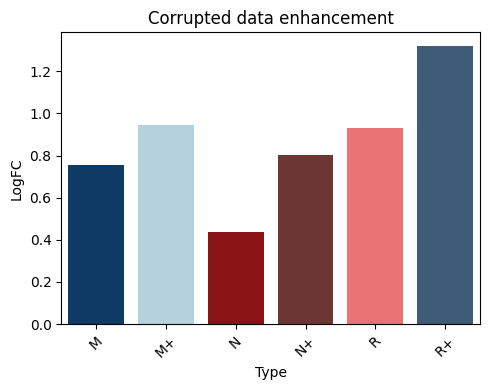

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt


hue_order = name
print(hue_order)
custom_palette = [ "#003A75", "#AED4E5","#9F0000",'#762E29','#FD5F5E','#345D82']

plt.figure(figsize=(5, 4))

sns.barplot(
    data=long_df,
    x='type',
    y='logFC',
    ci=None,
    palette=custom_palette, 
    hue_order=hue_order,
)

plt.title('Corrupted data enhancement')
plt.xlabel('Type')
plt.ylabel('LogFC')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(path + '/marker_enh_all.pdf',dpi=300)